## Пробное программирование

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.utils import shuffle 

import pandas as pd
import numpy as np

Загружаем и "обрабатываем" данные. Как видно, все признаки имеют тип float, а тип стекла - int.

In [3]:
df = pd.read_csv('glass.csv')

df.drop(['Id'], axis = 1, inplace = True)

df.dtypes

RI               float64
Na               float64
Mg               float64
Al               float64
Si               float64
K                float64
Ca               float64
Ba               float64
Fe               float64
Type_of_glass      int64
dtype: object

In [406]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [407]:
df.tail()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
209,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,7
213,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,7


Т.к. записи упорядочены по типу стекла, перемешаем строки.

In [4]:
df = shuffle(df) 
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
169,1.51994,13.27,0.00,1.76,73.03,0.47,11.32,0.00,0.00,5
51,1.51926,13.20,3.33,1.28,72.36,0.60,9.14,0.00,0.11,1
150,1.51665,13.14,3.45,1.76,72.48,0.60,8.38,0.00,0.17,3
15,1.51761,12.81,3.54,1.23,73.24,0.58,8.39,0.00,0.00,1
200,1.51508,15.15,0.00,2.25,73.50,0.00,8.34,0.63,0.00,7


Разделим датасет на обучающую выборку и тест. Оставим на тест 30%.

In [5]:
y = df['Type_of_glass']
X = df.copy()
X.drop('Type_of_glass', axis = 1, inplace = True)

X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, y, test_size = .3)

## Решающее дерево

In [410]:
dec_tree = DecisionTreeClassifier(criterion='entropy')

dec_tree.fit(X_train, y_train)

dec_tree.score(X_train, y_train)

1.0

Если строить дерево без ограничения глубины, то оно идеально подстроится под обучающую выборку.

In [411]:
dec_tree.score(X_holdout, y_holdout)

0.6153846153846154

Точность на отложеных данных - 61.5%.

Теперь будем использовать кросс-валидацию. Оптимизируем максимальную глубину дерева.

In [412]:
tree_params = {'max_depth': range(1, 11, 1)}

cv_best_tree = GridSearchCV(dec_tree, tree_params, cv = 4, n_jobs = 4, verbose = True)

cv_best_tree.fit(X_train, y_train)

print("Best params:", cv_best_tree.best_params_)
print("Best cross validaton score", cv_best_tree.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best params: {'max_depth': 7}
Best cross validaton score 0.6577181208053692


[Parallel(n_jobs=4)]: Done  33 out of  40 | elapsed:    8.2s remaining:    1.7s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    8.2s finished


Оптимальная глубина - 7.

In [413]:
cv_best_tree.score(X_holdout, y_holdout)

0.6307692307692307

Точность на отложенных данных - 63.1%.

## Метод ближайших соседей

In [414]:
knn = KNeighborsClassifier(n_neighbors = 10, n_jobs = 4) #10 ближайших соседей

knn.fit(X_train, y_train)

knn.score(X_train, y_train)

0.6778523489932886

Метод ближайших соседей на обучающей выборке дает точность 67.8%.

In [415]:
knn.score(X_holdout, y_holdout)

0.6461538461538462

На отложенных данных - 64.6%.

Теперь будем оптимизировать количество ближайших соседей и их веса (одинаковые, либо то расстояния).

In [416]:
weights = ['uniform', 'distance']
knn_params = {'n_neighbors': range(1, 21, 1), 'weights': weights}

cv_best_knn = GridSearchCV(knn, knn_params, cv = 4, n_jobs = 4, verbose = True)

cv_best_knn.fit(X_train, y_train)

print("Best params:", cv_best_knn.best_params_)
print("Best cross validaton score", cv_best_knn.best_score_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.2s


Best params: {'n_neighbors': 3, 'weights': 'distance'}
Best cross validaton score 0.6845637583892618


[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.4s finished


Модель определила, что лучше всего использовать 3х соседей и веса, зависящие от расстояния.

In [417]:
cv_best_knn.score(X_holdout, y_holdout)

0.6923076923076923

Точность на тестовых данных - 69.2%.

## Пробный анализ ошибки (метод ближайших соседей)

In [453]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

Мы хотим построить графики зависимости значений ошибки и ее стандартного отклонения от объема выборки на обучении и контроле.

In [419]:
df.shape

(214, 10)

В датасете 214 записей.

In [425]:
test_size = np.linspace(0.2, 0.8, 14)

test_acc_error = []
test_squ_error = []

train_acc_error = []
train_squ_error = []

for i in test_size:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, y, test_size = i)
    cv_best_knn.fit(X_train, y_train)

    cv_best_knn_prediction_train = cv_best_knn.predict(X_train)
    cv_best_knn_prediction_test = cv_best_knn.predict(X_holdout)

    train_acc_error.append(1 - accuracy_score(cv_best_knn_prediction_train, y_train))
    train_squ_error.append(mean_squared_error(cv_best_knn_prediction_train, y_train))

    test_acc_error.append(1 - accuracy_score(cv_best_knn_prediction_test, y_holdout))
    test_squ_error.append(mean_squared_error(cv_best_knn_prediction_test, y_holdout))

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.8s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.3s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   17.1s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   17.6s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.9s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.8s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   17.2s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.9s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   17.6s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.3s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.2s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.9s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 153 out of 160 | elapsed:   16.0s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   16.2s finished


Fitting 4 folds for each of 40 candidates, totalling 160 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   14.4s finished


In [452]:
data_acc_err = pd.DataFrame(data=[test_size, test_acc_error, train_acc_error]).transpose()
data_acc_err.columns = ['объем тестовых данных', 'средняя ошибка на тестовых данных', 'средняя ошибка на обучающей выборке']

data_squ_err = pd.DataFrame(data=[test_size, test_squ_error, train_squ_error]).transpose()
data_squ_err.columns = ['объем тестовых данных', 'среднеквадратичная ошибка на тестовых данных', 'среднеквадратичная ошибка на обучающей выборке']

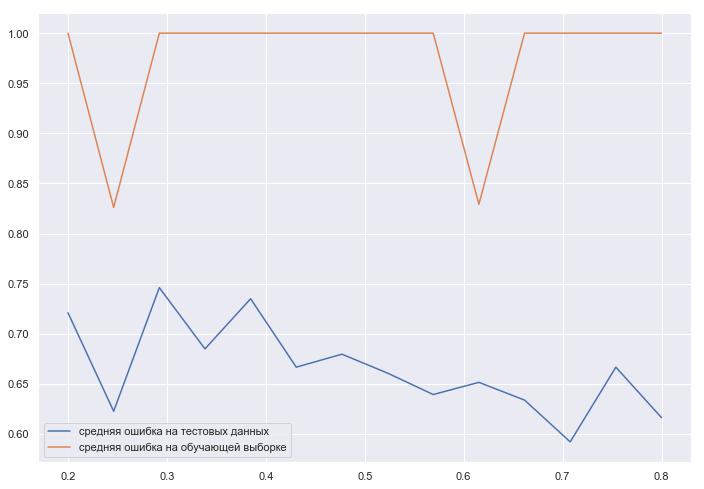

In [454]:
plt.plot( 'объем тестовых данных', 'средняя ошибка на тестовых данных', data=data_acc_err)
plt.plot( 'объем тестовых данных', 'средняя ошибка на обучающей выборке', data=data_acc_err)
plt.legend()

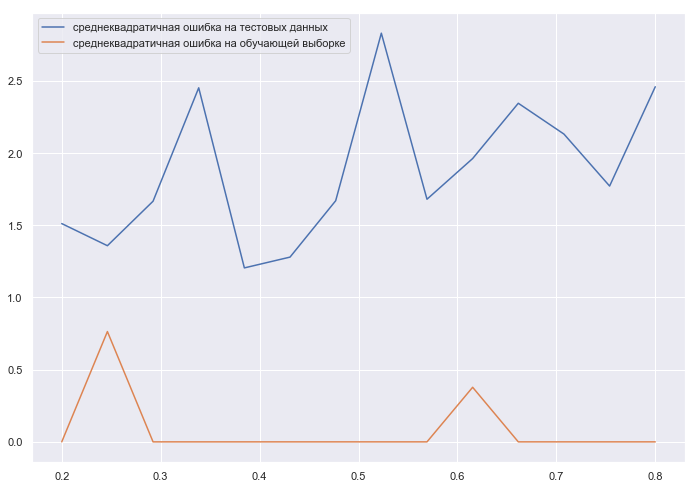

In [455]:
plt.plot( 'объем тестовых данных', 'среднеквадратичная ошибка на тестовых данных', data=data_squ_err)
plt.plot( 'объем тестовых данных', 'среднеквадратичная ошибка на обучающей выборке', data=data_squ_err)
plt.legend()s